In [1]:
#import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim import utils
import gensim
import multiprocessing
cores = multiprocessing.cpu_count()
import os
from time import time
import torch
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader

In [ ]:
# To notify when cell is complete (comment out first line)
# !pip uninstall jupyternotify -y
!pip install git+https://github.com/cphyc/jupyter-notify.git
%reload_ext jupyternotify

In [66]:
# read in cleaned CSV
filepath = Path('../massive.csv')
massive = pd.read_csv(filepath)
massive = massive.sample(n=15000)
massive.reset_index(drop=True, inplace=True)

In [70]:
# Dropping columns including audienceScore because it could unfairly help the model predict the delta. Leaving tomatoMeter to give the model a base of where the delta could be.
massive = massive.drop(columns=['id', 'reviewId', 'creationDate', 'isTopCritic', 'reviewState', 'audienceScore'])
massive.head(1)

In [72]:
massive.isnull().sum()

title             0
tomatoMeter       0
criticName        0
publicatioName    0
reviewText        0
scoreSentiment    0
delta             0
dtype: int64

In [73]:
# Dropping duplicates
massive = massive.drop_duplicates(subset='reviewText', keep='first')
# Resetting index after dropping dupe's
massive.reset_index(drop=True, inplace=True)
# Checking for duplicates
dup_df = massive.apply(lambda x: x.duplicated()).sum()
dup_df

title              7256
tomatoMeter       14876
criticName        11857
publicatioName    13494
reviewText            0
scoreSentiment    14974
delta             14854
dtype: int64

In [74]:
# Pulling BERT from huggingface
tokenizer = AutoTokenizer.from_pretrained("activebus/BERT_Review")
model = AutoModel.from_pretrained("activebus/BERT_Review")

Some weights of the model checkpoint at activebus/BERT_Review were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [75]:
# Text preprocessing function
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
# Function to vectorize text with BERT
def get_embedding(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    features = model(**encoded_input)
    features = features[0].detach().numpy() 
    features_mean = np.mean(features[0], axis=0) 
    return features_mean
# Applying the function to reviewText and outputting to embeddings column
massive['embeddings'] = massive.reviewText.map(lambda x: get_embedding(x))
massive.head()

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,embeddings
0,Mr. Deeds,22.0,Robin Clifford,Reeling Reviews,"""Mr. Deeds"" is suitable summer entertainment t...",POSITIVE,-37.0,"[-0.32600164, 0.61281604, 0.16838151, -0.01734..."
1,I Am Not Your Negro,99.0,Sean Nelson,"The Stranger (Seattle, WA)",An ingeniously constructed documentary about o...,POSITIVE,16.0,"[-0.1996221, 0.37342745, -0.046215247, -0.1627..."
2,The Man Who Knew Infinity,63.0,Marsha Lederman,Globe and Mail,When one of the most enlightening moments of a...,NEGATIVE,-8.0,"[-0.32620835, 0.5845065, -0.0119517725, -0.129..."
3,Last Chance Harvey,71.0,Linda Cook,"Quad City Times (Davenport, IA)",Sometimes it's nice to be reminded that romanc...,POSITIVE,18.0,"[-0.006058085, -0.00083954335, -0.09051174, 0...."
4,Café Lumière,91.0,Ted Fry,Seattle Times,The film often takes on the hypnotic rhythm of...,POSITIVE,14.0,"[0.07741421, 0.46812433, 0.20540753, -0.115314..."


In [ ]:
# Converting embeddings column to numpy array
vectors = np.array(massive.embeddings.tolist(), dtype='float')
vectors[:10]

In [77]:
# Flattening numpy array and creating dataframe with it
v_df = pd.DataFrame(vectors, columns=[f'col{i+1}' for i in range(vectors.shape[1])])
v_df.head(3)

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
0,-0.326002,0.612816,0.168382,-0.017348,0.542521,-0.195864,0.175667,0.291534,-0.042749,-0.298336,...,-0.098349,-0.258789,0.061945,-0.048800,0.044166,-0.255626,0.332104,-0.113984,0.170599,-0.026536
1,-0.199622,0.373427,-0.046215,-0.162763,0.161503,-0.090786,0.093958,0.354282,0.015286,-0.198374,...,0.118767,-0.257988,0.020987,-0.173951,-0.197309,-0.219377,0.157864,-0.137923,0.240960,0.034384
2,-0.326208,0.584507,-0.011952,-0.129251,0.277130,0.050193,0.047537,0.587490,-0.165023,-0.215091,...,-0.018306,-0.191655,0.139052,-0.196631,-0.181573,-0.082238,0.186720,-0.109939,0.048487,0.265249


In [78]:
# Dropping review text now it is vectorized, and dropping embeddings now that it is flattened
massive = massive.drop(columns=['reviewText', 'embeddings'])

In [79]:
massive.isnull().sum().head(9)

title             0
tomatoMeter       0
criticName        0
publicatioName    0
scoreSentiment    0
delta             0
embeddings        0
dtype: int64

In [80]:
# Renaming the least-appearing critics as Other to later be encoded as the same critic
counts = massive.criticName.value_counts()
threshold = massive.criticName.isin(counts.index[counts<16])
massive.loc[threshold, 'criticName'] = 'Other'
massive['criticName'].value_counts()

Other                  9153
Jeffrey M. Anderson     100
Dennis Schwartz          95
David Nusair             86
Roger Ebert              86
                       ... 
Rick Groen               16
Danielle Solzman         16
Robert Kojder            16
Liz Braun                16
Glenn Whipp              16
Name: criticName, Length: 211, dtype: int64

In [81]:
# Repeat for publications
counts = massive.publicatioName.value_counts()
threshold = massive.publicatioName.isin(counts.index[counts<12])
massive.loc[threshold, 'publicatioName'] = 'Other'
massive['publicatioName'].value_counts()

Other                                  4209
New York Times                          202
Variety                                 163
Los Angeles Times                       151
Slant Magazine                          123
                                       ... 
Next Best Picture                        12
The Movie Minute                         12
KDHX (St. Louis)                         12
Northwest Herald (Crystal Lake, IL)      12
Dread Central                            12
Name: publicatioName, Length: 334, dtype: int64

In [82]:
# List of columns to dummy
categorical_cols = ['title', 'criticName', 'publicatioName', 'scoreSentiment'] 
# Get dummies on categorical columns
massive = pd.get_dummies(massive, columns = categorical_cols)

In [101]:
# Merging massive df with vectorized df
combined = pd.concat([massive, v_df], axis=1)
combined.head(1)

,tomatoMeter,delta,title_#Unfit: The Psychology of Donald Trump,title_$9.99,title_$upercapitalist,title_'71,title_(500) Days of Summer,title_(Untitled),title_... And They Lived Happily Ever After,title_...So Goes the Nation,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
0,22.0,-37.0,0,0,0,0,0,0,0,0,...,-0.098349,-0.258789,0.061945,-0.0488,0.044166,-0.255626,0.332104,-0.113984,0.170599,-0.026536


In [102]:
X = combined.drop(columns=['delta'])
y = combined['delta']

In [105]:
X.isnull().sum().sum()

0

In [92]:
y[:5]

0   -37.0
1    16.0
2    -8.0
3    18.0
4    14.0
Name: delta, dtype: float64

In [107]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [109]:
%%notify
# Scaling X
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [148]:
%%notify
# PCA to filter most important features
pca = PCA(n_components=6000)
X_train_p = pca.fit_transform(X_train_sc)
X_test_p = pca.transform(X_test_sc)

<IPython.core.display.Javascript object>

In [149]:
%%notify
# Training learning model
model = LinearRegression()
model.fit(X_train_p, y_train)

LinearRegression()

<IPython.core.display.Javascript object>

In [150]:
model.score(X_train_p, y_train)

0.9227881013926973

In [151]:
model.score(X_test_p, y_test)

0.5212681489904241

In [152]:
y_pred = model.predict(X_test_p)

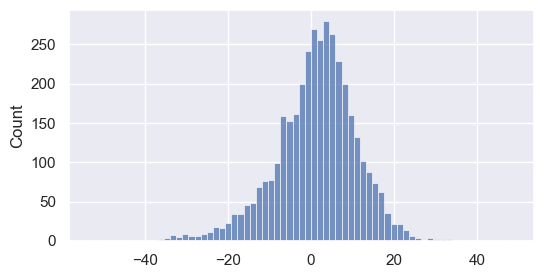

In [157]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=y_pred)
plt.savefig('BERT_linear_predictions.png')

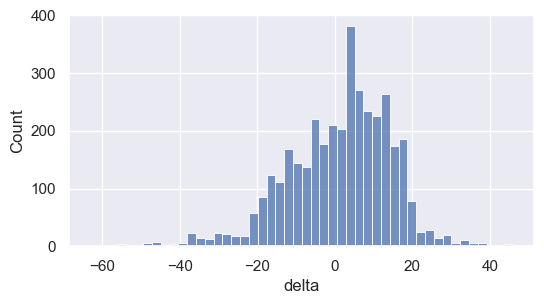

In [158]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=y_test)
plt.savefig('BERT_linear_ytest.png')